## convert the mask images to labeled images with bounding boxes for Object Detection

### first let's splite the Data into folders

In [7]:
import os
import shutil
import cv2

# Define the path to the metadata folder
metadata_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\metadata\metadata"

# Define the path to the source data folder
source_image_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\images\images"
source_mask_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\masks\masks"

# Define the path to the destination folders
destination_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN"
train_folder = os.path.join(destination_folder, "train")
validation_folder = os.path.join(destination_folder, "validation")
test_folder = os.path.join(destination_folder, "test")

# Create the destination folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Read the file paths from the metadata files
def read_file_paths(file_path):
    with open(file_path, "r") as file:
        file_paths = [line.strip() for line in file]
    return file_paths

# Get the file paths from the metadata files
train_file_paths = read_file_paths(os.path.join(metadata_folder, "training.txt"))
validation_file_paths = read_file_paths(os.path.join(metadata_folder, "validation.txt"))
test_file_paths = read_file_paths(os.path.join(metadata_folder, "test.txt"))

# Copy files to the destination folders and resize the images
def copy_files(file_paths, source_image_folder, source_mask_folder, destination_folder, target_size):
    for file_path in file_paths:
        file_name = os.path.splitext(file_path)[0]  # Get the file name without extension
        
        source_image_path = os.path.join(source_image_folder, file_name + ".tif")
        destination_image_path = os.path.join(destination_folder, "images", file_name + ".tif")
        
        source_mask_path = os.path.join(source_mask_folder, file_name + ".png")
        destination_mask_path = os.path.join(destination_folder, "masks", file_name + ".png")
        
        os.makedirs(os.path.dirname(destination_image_path), exist_ok=True)
        os.makedirs(os.path.dirname(destination_mask_path), exist_ok=True)
        
        # Read and resize the image
        image = cv2.imread(source_image_path)
        image = cv2.resize(image, target_size)
        
        # Copy the colored mask
        shutil.copyfile(source_mask_path, destination_mask_path)
        
        # Save the resized image
        cv2.imwrite(destination_image_path, image)

# Target size for resizing
target_size = (512, 512)

# Copy training files and resize the images
copy_files(train_file_paths, source_image_folder, source_mask_folder, train_folder, target_size)

# Copy validation files and resize the images
copy_files(validation_file_paths, source_image_folder, source_mask_folder, validation_folder, target_size)

# Copy test files and resize the images
copy_files(test_file_paths, source_image_folder, source_mask_folder, test_folder, target_size)


# men houni ==>

### convert the mask images for each folder to labeled images with bounding boxes

#### Training Folder


In [21]:
import os
import numpy as np
import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.draw
import matplotlib.pyplot as plt
from tqdm import tqdm

mask_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\train\masks"
output_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\train\masksboxes"

min_nucleus_size = 25
boundary_size = 2

filelist = sorted(os.listdir(mask_folder))
total_objects = 0
bounding_boxes = []

# Create a text file to store the bounding box targets
target_file = open(r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\train\masksboxes\bounding_box_targets.txt", "w")

for filename in tqdm(filelist):
    if filename.endswith(".png"):
        # Get mask image
        mask = skimage.io.imread(os.path.join(mask_folder, filename))

        # Keep the first channel only
        mask = mask[:, :, 0]

        # Label independent connected components
        mask = skimage.morphology.label(mask)

        # Convert to binary image
        mask_binary = np.zeros_like(mask)
        mask_binary[mask > 0] = 1

        # Find boundaries
        boundaries = skimage.segmentation.find_boundaries(mask_binary)

        for k in range(2, boundary_size, 2):  # Adjust the boundary_size as needed
            boundaries = skimage.morphology.binary_dilation(boundaries)

        # Prepare buffer for binary label
        label_binary = np.zeros((mask.shape + (3,)))

        # Write binary label
        label_binary[(mask_binary == 0) & (boundaries == 0), 0] = 1
        label_binary[(mask_binary != 0) & (boundaries == 0), 1] = 1
        label_binary[boundaries == 1, 2] = 1

        # Compute region properties (bounding box) for each labeled region
        regions = skimage.measure.regionprops(mask)

        # Draw bounding boxes on the labeled image
        labeled_image = (label_binary * 255).astype(np.uint8)
        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            labeled_image[minr:minr+2, minc:maxc] = [0, 0, 255]  # Top
            labeled_image[maxr-2:maxr, minc:maxc] = [0, 0, 255]  # Bottom
            labeled_image[minr:maxr, minc:minc+2] = [0, 0, 255]  # Left
            labeled_image[minr:maxr, maxc-2:maxc] = [0, 0, 255]  # Right
            # Add bounding box coordinates to the list
            bounding_boxes.append((filename, minc, minr, maxc, maxr))

        # Resize the labeled image to 512x512
        resized_labeled_image = cv2.resize(labeled_image, (512, 512))

        # Save the resized labeled image with bounding boxes
        output_path = os.path.join(output_folder, filename)
        skimage.io.imsave(output_path, resized_labeled_image)

class_label=1        
# Write the bounding box coordinates as targets
for box in bounding_boxes:
    filename, minc, minr, maxc, maxr = box
    target_line = f"{filename},{minc},{minr},{maxc},{maxr},{class_label}\n"
    target_file.write(target_line)

# Close the target file
target_file.close()


 34%|███████████████████████████▌                                                     | 34/100 [00:07<00:13,  4.79it/s]C:\Users\mArK\AppData\Local\Temp\ipykernel_24096\437316116.py:71: UserWarning: C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\train\masksboxes\IXMtest_F13_s7_w13C1B1D8C-293E-454F-B0FD-6C2C3F9F5173.png is a low contrast image
  skimage.io.imsave(output_path, resized_labeled_image)
 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:14<00:06,  4.51it/s]C:\Users\mArK\AppData\Local\Temp\ipykernel_24096\437316116.py:71: UserWarning: C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\train\masksboxes\IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174.png is a low contrast image
  skimage.io.imsave(output_path, resized_labeled_image)
 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:20<00:00,  5.19it/s]C:\Users\mArK\AppData\Local\Temp\ipykerne

#### Test Folder

In [22]:
import os
import numpy as np
import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.draw
import matplotlib.pyplot as plt
from tqdm import tqdm

mask_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\test\masks"
output_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\test\masksboxes"

min_nucleus_size = 25
boundary_size = 2

filelist = sorted(os.listdir(mask_folder))
total_objects = 0
bounding_boxes = []

# Create a text file to store the bounding box targets
target_file = open(r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\test\masksboxes\bounding_box_targets.txt", "w")

for filename in tqdm(filelist):
    if filename.endswith(".png"):
        # Get mask image
        mask = skimage.io.imread(os.path.join(mask_folder, filename))

        # Keep the first channel only
        mask = mask[:, :, 0]

        # Label independent connected components
        mask = skimage.morphology.label(mask)

        # Convert to binary image
        mask_binary = np.zeros_like(mask)
        mask_binary[mask > 0] = 1

        # Find boundaries
        boundaries = skimage.segmentation.find_boundaries(mask_binary)

        for k in range(2, boundary_size, 2):  # Adjust the boundary_size as needed
            boundaries = skimage.morphology.binary_dilation(boundaries)

        # Prepare buffer for binary label
        label_binary = np.zeros((mask.shape + (3,)))

        # Write binary label
        label_binary[(mask_binary == 0) & (boundaries == 0), 0] = 1
        label_binary[(mask_binary != 0) & (boundaries == 0), 1] = 1
        label_binary[boundaries == 1, 2] = 1

        # Compute region properties (bounding box) for each labeled region
        regions = skimage.measure.regionprops(mask)

        # Draw bounding boxes on the labeled image
        labeled_image = (label_binary * 255).astype(np.uint8)
        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            labeled_image[minr:minr+2, minc:maxc] = [0, 0, 255]  # Top
            labeled_image[maxr-2:maxr, minc:maxc] = [0, 0, 255]  # Bottom
            labeled_image[minr:maxr, minc:minc+2] = [0, 0, 255]  # Left
            labeled_image[minr:maxr, maxc-2:maxc] = [0, 0, 255]  # Right
            # Add bounding box coordinates to the list
            bounding_boxes.append((filename, minc, minr, maxc, maxr))

        # Resize the labeled image to 512x512
        resized_labeled_image = cv2.resize(labeled_image, (512, 512))

        # Save the resized labeled image with bounding boxes
        output_path = os.path.join(output_folder, filename)
        skimage.io.imsave(output_path, resized_labeled_image)

# Write the bounding box coordinates as targets
for box in bounding_boxes:
    filename, minc, minr, maxc, maxr = box
    target_line = f"{filename},{minc},{minr},{maxc},{maxr},{class_label}\n"
    target_file.write(target_line)

# Close the target file
target_file.close()


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.92it/s]


In [23]:
import os
import numpy as np
import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.draw
import matplotlib.pyplot as plt
from tqdm import tqdm

mask_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\validation\masks"
output_folder = r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\validation\masksboxes"
min_nucleus_size = 25
boundary_size = 2

filelist = sorted(os.listdir(mask_folder))
total_objects = 0
bounding_boxes = []

# Create a text file to store the bounding box targets
target_file = open(r"C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\validation\masksboxes\bounding_box_targets.txt", "w")

for filename in tqdm(filelist):
    if filename.endswith(".png"):
        # Get mask image
        mask = skimage.io.imread(os.path.join(mask_folder, filename))

        # Keep the first channel only
        mask = mask[:, :, 0]

        # Label independent connected components
        mask = skimage.morphology.label(mask)

        # Convert to binary image
        mask_binary = np.zeros_like(mask)
        mask_binary[mask > 0] = 1

        # Find boundaries
        boundaries = skimage.segmentation.find_boundaries(mask_binary)

        for k in range(2, boundary_size, 2):  # Adjust the boundary_size as needed
            boundaries = skimage.morphology.binary_dilation(boundaries)

        # Prepare buffer for binary label
        label_binary = np.zeros((mask.shape + (3,)))

        # Write binary label
        label_binary[(mask_binary == 0) & (boundaries == 0), 0] = 1
        label_binary[(mask_binary != 0) & (boundaries == 0), 1] = 1
        label_binary[boundaries == 1, 2] = 1

        # Compute region properties (bounding box) for each labeled region
        regions = skimage.measure.regionprops(mask)

        # Draw bounding boxes on the labeled image
        labeled_image = (label_binary * 255).astype(np.uint8)
        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            labeled_image[minr:minr+2, minc:maxc] = [0, 0, 255]  # Top
            labeled_image[maxr-2:maxr, minc:maxc] = [0, 0, 255]  # Bottom
            labeled_image[minr:maxr, minc:minc+2] = [0, 0, 255]  # Left
            labeled_image[minr:maxr, maxc-2:maxc] = [0, 0, 255]  # Right
            # Add bounding box coordinates to the list
            bounding_boxes.append((filename, minc, minr, maxc, maxr))

        # Resize the labeled image to 512x512
        resized_labeled_image = cv2.resize(labeled_image, (512, 512))

        # Save the resized labeled image with bounding boxes
        output_path = os.path.join(output_folder, filename)
        skimage.io.imsave(output_path, resized_labeled_image)

# Write the bounding box coordinates as targets
for box in bounding_boxes:
    filename, minc, minr, maxc, maxr = box
    target_line = f"{filename},{minc},{minr},{maxc},{maxr},{class_label}\n"
    target_file.write(target_line)

# Close the target file 
target_file.close()


 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:07<00:03,  4.35it/s]C:\Users\mArK\AppData\Local\Temp\ipykernel_24096\2841790612.py:70: UserWarning: C:\Users\mArK\Desktop\computer vision\projekt 2\splitted_data_RCNN\validation\masksboxes\IXMtest_L10_s6_w12D12D64C-2639-4CA8-9BB4-99F92C9B7068.png is a low contrast image
  skimage.io.imsave(output_path, resized_labeled_image)
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.76it/s]


## Read a labeled image with box example

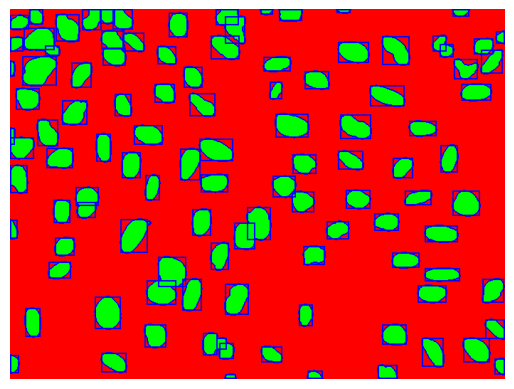

In [24]:

image_path = "C:/Users/mArK/Desktop/computer vision/projekt 2/boundary_labels_with_boxes/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png"
image = skimage.io.imread(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()


### Create the data loaders


In [25]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path, targets_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.targets_path = targets_path
        self.n_samples = len(images_path)
        print("Targets Path:", self.targets_path)  # Print the targets_path


    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        # Convert the image array to a PyTorch tensor
        image = torch.from_numpy(image)
        print(self.images_path[index])

        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_COLOR)
        mask = mask / 255.0
        mask = np.transpose(mask, (2, 0, 1))
        mask = mask.astype(np.float32)
        # Convert the mask array to a PyTorch tensor
        mask = torch.from_numpy(mask)
        #print(self.masks_path[index])
        

        image_filename = os.path.basename(self.masks_path[index])
        #print(image_filename)
        # Create empty lists to store the bounding boxes and class labels
        boxes_coordinates_list = []
        class_labels_list = []

        # Find the corresponding target line for the current image filename
        with open(self.targets_path, "r") as f:
            for line in f:
                components = line.strip().split(",")
            
                
                if components[0] == image_filename:
                    
                    boxes_coordinates = np.array([float(coord) for coord in components[1:5]])
                    class_label = int(components[5])
                    boxes_coordinates_list.append(boxes_coordinates)
                    class_labels_list.append(class_label)
                    

                    
           
        # Convert the lists of bounding boxes and class labels to numpy arrays
        boxes_coordinates_array = np.array(boxes_coordinates_list)
        class_labels_array = np.array(class_labels_list)
        #print(len(boxes_coordinates_array))
        #print(len(class_labels_array))
        return image, mask, boxes_coordinates_array, class_labels_array
       

    def __len__(self):
        return self.n_samples

# Define the paths to the train, validation, and test folders
train_images_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/images"
train_masks_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/masksboxes"
train_targets_file = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/masksboxes/bounding_box_targets.txt"

valid_images_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/validation/images"
valid_masks_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/validation/masksboxes"
valid_targets_file = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/validation/masksboxes/bounding_box_targets.txt"

test_images_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/test/images"
test_masks_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/test/masksboxes"
test_targets_file = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/test/masksboxes/bounding_box_targets.txt"




# Create the DriveDataset instances
train_dataset = DriveDataset(
    [os.path.join(train_images_folder, image) for image in sorted(os.listdir(train_images_folder))],
    [os.path.join(train_masks_folder, mask) for mask in sorted(os.listdir(train_masks_folder))],
    train_targets_file
)

valid_dataset = DriveDataset(
    [os.path.join(valid_images_folder, image) for image in sorted(os.listdir(valid_images_folder))],
    [os.path.join(valid_masks_folder, mask) for mask in sorted(os.listdir(valid_masks_folder))],
    valid_targets_file
)

test_dataset = DriveDataset(
    [os.path.join(test_images_folder, image) for image in sorted(os.listdir(test_images_folder))],
    [os.path.join(test_masks_folder, mask) for mask in sorted(os.listdir(test_masks_folder))],
    test_targets_file
)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
print(len(train_loader))
# 100 / 2 (batch size) = 50
print(len(test_loader))

Targets Path: C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/masksboxes/bounding_box_targets.txt
Targets Path: C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/validation/masksboxes/bounding_box_targets.txt
Targets Path: C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/test/masksboxes/bounding_box_targets.txt
100
50


In [14]:
# Iterate over the data loader
for batch_idx, (images, masks, boxes_coordinates, class_labels) in enumerate(train_loader):
    # Print the batch index
    print("Batch index:", batch_idx)

    # Print the shape and data type of the batch tensors
    print("Batch shape:")
    print("Images:", images.shape)
    print("Masks:", masks.shape)
    print("Boxes Coordinates:", boxes_coordinates)
    print("Class Labels:", class_labels)
    print()
    print(boxes_coordinates.shape)
    print("Batch data type:")
    print("Images:", images.dtype)
    print("Masks:", masks.dtype)
    print()
    break


C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/images\IXMtest_B21_s4_w1521471E0-9BD7-492A-8739-9C782C2585B0.tif
Batch index: 0
Batch shape:
Images: torch.Size([1, 3, 512, 512])
Masks: torch.Size([1, 3, 512, 512])
Boxes Coordinates: tensor([], size=(1, 0), dtype=torch.float64)
Class Labels: tensor([], size=(1, 0), dtype=torch.float64)

torch.Size([1, 0])
Batch data type:
Images: torch.float32
Masks: torch.float32



Since the "Boxes Coordinates" tensors have different shapes for different samples in the batch, it means that the number of bounding boxes (rows) varies between the samples.


If batches have different tensor shapes, it can lead to errors during training or inference in the Faster R-CNN model. The model expects consistent tensor shapes within each batch to perform operations such as forward pass, loss computation, and gradient updates.

To address this issue, you can use padding or resizing techniques to ensure that all tensors within a batch have the same shape. Padding involves adding elements (e.g., zeros) to smaller tensors to match the shape of the largest tensor in the batch. 

Based on the output, the shapes of the tensors are as follows:

1. Images: [2, 3, 512, 512] (2 images because each batch has 2 samples , 3 channels, 512x512 resolution)

2. Masks: [2, 3, 512, 512] (2 masks, 3 channels, 520x696 resolution)


# let s try without batch size

In [26]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path, targets_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.targets_path = targets_path
        self.n_samples = len(images_path)
        print("Targets Path:", self.targets_path)  # Print the targets_path

    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        # Convert the image array to a PyTorch tensor
        image = torch.from_numpy(image)

        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_COLOR)
        mask = mask / 255.0
        mask = np.transpose(mask, (2, 0, 1))
        mask = mask.astype(np.float32)
        # Convert the mask array to a PyTorch tensor
        mask = torch.from_numpy(mask)

        image_filename = os.path.basename(self.masks_path[index])
        #print(image_filename)
        # Create empty lists to store the bounding boxes and class labels
        boxes_coordinates_list = []
        class_labels_list = []

        # Find the corresponding target line for the current image filename
        with open(self.targets_path, "r") as f:
            for line in f:
                components = line.strip().split(",")

                if components[0] == image_filename:
                    boxes_coordinates = np.array([float(coord) for coord in components[1:5]])
                    class_label = int(components[5])
                    boxes_coordinates_list.append(boxes_coordinates)
                    class_labels_list.append(class_label)

        # Convert the lists of bounding boxes and class labels to numpy arrays
        boxes_coordinates_array = np.array(boxes_coordinates_list)
        class_labels_array = np.array(class_labels_list)
        #print(len(boxes_coordinates_array))
        #print(len(class_labels_array))
        return image, mask, boxes_coordinates_array, class_labels_array

    def __len__(self):
        return self.n_samples


# Define the paths to the train, validation, and test folders
train_images_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/images"
train_masks_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/masksboxes"
train_targets_file = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/masksboxes/bounding_box_targets.txt"

valid_images_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/validation/images"
valid_masks_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/validation/masksboxes"
valid_targets_file = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/validation/masksboxes/bounding_box_targets.txt"

test_images_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/test/images"
test_masks_folder = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/test/masksboxes"
test_targets_file = "C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/test/masksboxes/bounding_box_targets.txt"

# Create the DriveDataset instances
train_dataset = DriveDataset(
    [os.path.join(train_images_folder, image) for image in sorted(os.listdir(train_images_folder))],
    [os.path.join(train_masks_folder, mask) for mask in sorted(os.listdir(train_masks_folder))],
    train_targets_file
)

valid_dataset = DriveDataset(
    [os.path.join(valid_images_folder, image) for image in sorted(os.listdir(valid_images_folder))],
    [os.path.join(valid_masks_folder, mask) for mask in sorted(os.listdir(valid_masks_folder))],
    valid_targets_file
)

test_dataset = DriveDataset(
    [os.path.join(test_images_folder, image) for image in sorted(os.listdir(test_images_folder))],
    [os.path.join(test_masks_folder, mask) for mask in sorted(os.listdir(test_masks_folder))],
    test_targets_file
)

# Create the data loaders
train_loader = DataLoader(train_dataset, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=0)
print(len(train_loader))
print(len(test_loader))


Targets Path: C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/train/masksboxes/bounding_box_targets.txt
Targets Path: C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/validation/masksboxes/bounding_box_targets.txt
Targets Path: C:/Users/mArK/Desktop/computer vision/projekt 2/splitted_data_RCNN/test/masksboxes/bounding_box_targets.txt
100
50


In [28]:
for sample_idx, (image, mask, boxes_coordinates, class_labels) in enumerate(train_loader):
    print("Sample index:", sample_idx)
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    print("Boxes Coordinates shape:", boxes_coordinates)
    print("Class Labels shape:", class_labels)

    print(class_labels)
    print(class_labels.shape)
    print(image.dtype)
    print()
    break


Sample index: 0
Image shape: torch.Size([1, 3, 512, 512])
Mask shape: torch.Size([1, 3, 512, 512])
Boxes Coordinates shape: tensor([[[ 84.,   0., 109.,  25.],
         [246.,   0., 270.,  10.],
         [346.,   0., 383.,  14.],
         [411.,   0., 451.,  36.],
         [579.,   0., 602.,  20.],
         [664.,   0., 696.,  27.],
         [546.,   8., 576.,  43.],
         [104.,   9., 133.,  50.],
         [314.,   9., 349.,  46.],
         [143.,  10., 167.,  39.],
         [269.,  13., 299.,  54.],
         [  0.,  14.,  15.,  44.],
         [185.,  18., 215.,  41.],
         [234.,  28., 255.,  60.],
         [466.,  37., 495.,  67.],
         [ 23.,  45.,  53.,  68.],
         [189.,  47., 219.,  72.],
         [532.,  47., 558.,  81.],
         [374.,  49., 402.,  75.],
         [564.,  52., 593.,  90.],
         [423.,  61., 453.,  89.],
         [155.,  62., 187.,  95.],
         [639.,  77., 681., 101.],
         [207.,  81., 242., 102.],
         [290.,  81., 316., 110.],
 

In [18]:
for sample_idx, (image, mask, boxes_coordinates, class_labels) in enumerate(valid_loader):
    print("Sample index:", sample_idx)
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    #print("Boxes Coordinates shape:", boxes_coordinates)
    #print("Class Labels shape:", class_labels)
    print(boxes_coordinates.shape)
    print(class_labels.shape)
    print(image.dtype)
    print()
    break

Sample index: 0
Image shape: torch.Size([1, 3, 512, 512])
Mask shape: torch.Size([1, 3, 512, 512])
torch.Size([1, 0])
torch.Size([1, 0])
torch.float32



In [29]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

#Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Set the backbone network (e.g., ResNet50-FPN)
backbone = resnet_fpn_backbone('resnet50', pretrained=True).to(device)

#Create the anchor generator
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

anchor_generator = AnchorGenerator(sizes=anchor_sizes,
                                   aspect_ratios=aspect_ratios)

#Define the number of classes (including the background)
num_classes = 2

#Create the Faster R-CNN model
model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator).to(device)

#Print the model architecture
print(model)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
import torch
import torch.optim as optim

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10  # Set the number of epochs
best_valid_loss = float('inf')  # Initialize the best validation loss
checkpoint_path = "filesrCNN/checkpoint.pth"  # Path to save the best model checkpoint

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for image, mask, boxes, labels in train_loader:
        image = image.squeeze(0).to(device)
        mask = mask.squeeze(0).to(device)
        boxes = boxes.squeeze(0).to(device)  # Remove the batch dimension
        labels = labels.squeeze(0).to(device)

        optimizer.zero_grad()
        labels = labels.to(torch.int64)

        targets = {'masks': mask, 'boxes': boxes, 'labels': labels}

        if boxes.shape[0] > 0:
            #print("*")
            outputs = model([image], [targets])
            #print(outputs)
            #print(outputs)
            loss_classifier = outputs['loss_classifier']
            loss_box_reg = outputs['loss_box_reg']
            loss_objectness = outputs['loss_objectness']
            loss_rpn_box_reg = outputs['loss_rpn_box_reg']
            total_loss = loss_classifier + loss_box_reg + loss_objectness + loss_rpn_box_reg

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()

    train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}')
    

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation during validation
        for image, mask, boxes, labels in valid_loader:
            image = image.squeeze(0).to(device)
            mask = mask.squeeze(0).to(device)
            boxes = boxes.squeeze(0).to(device)  # Remove the batch dimension
            labels = labels.squeeze(0).to(device)  # Remove the batch dimension

            labels = labels.to(torch.int64)

            targets = {'masks': mask, 'boxes': boxes, 'labels': labels}
            if boxes.shape[0] > 0:
                outputsval = model([image], [targets])
                
                #print(outputsval)
                
                scores = outputsval[0]['scores']
                loss_value = torch.sum(scores)/len(scores)
                val_loss += loss_value.item()

    
    
    val_loss = val_loss / len(valid_loader)
    print(f'Validation Loss: {val_loss:.4f}')

    # Saving the best model checkpoint
    if val_loss < best_valid_loss:
        print(f'Valid loss improved from {best_valid_loss:.4f} to {val_loss:.4f}. Saving checkpoint: {checkpoint_path}')

        best_valid_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)


Epoch 1/10, Training Loss: 1.9214
Validation Loss: 0.3688
Valid loss improved from inf to 0.3688. Saving checkpoint: filesrCNN/checkpoint.pth
Epoch 2/10, Training Loss: 1.8827
Validation Loss: 0.3564
Valid loss improved from 0.3688 to 0.3564. Saving checkpoint: filesrCNN/checkpoint.pth
Epoch 3/10, Training Loss: 1.8810
Validation Loss: 0.3660
Epoch 4/10, Training Loss: 1.8811
Validation Loss: 0.3711
Epoch 5/10, Training Loss: 1.8823
Validation Loss: 0.3604
Epoch 6/10, Training Loss: 1.8920
Validation Loss: 0.3728
Epoch 7/10, Training Loss: 1.8691
Validation Loss: 0.4242
